# Simultaneous onset and model prediction

### Model definition
the following is the definition of the logistic model using a connectivity matrix

In [1]:
# TODO: get cognitive score implemented into beta optimization
# TODO: implement K_ij brain region into theta optimization
# TODO: implement jacobian for each theta 

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

seed = 1
np.random.seed(seed)

def get_adjacency_matrix(connectivity_matrix_type, n_biomarkers, seed = 1):
    if connectivity_matrix_type == 'offdiag':
        matrix = np.zeros((n_biomarkers, n_biomarkers))
        for i in range(n_biomarkers - 1):
            matrix[i, i + 1] = 1
            matrix[i + 1, i] = 1
        return matrix
    
    if connectivity_matrix_type == 'random_offdiag':
        np.random.seed(seed)
        matrix = np.zeros((n_biomarkers, n_biomarkers))
        
        # fully connect first offdiag
        first_off_diag_values = np.random.random(n_biomarkers - 1)
        np.fill_diagonal(matrix[1:], first_off_diag_values)
        np.fill_diagonal(matrix[:, 1:], first_off_diag_values)

        # further off diags
        for offset in range(2, 3): # just 2nd and 3rd for now
            sparsity = 0.1 * offset  
            scale = 1 / offset
            random_values = np.random.random(size=n_biomarkers - offset) * scale

            # apply sparsity mask (higher offset = more zeros)
            mask = np.random.rand(n_biomarkers - offset) > sparsity
            random_values *= mask  # Zero out some connections
            
            np.fill_diagonal(matrix[offset:], random_values)
            np.fill_diagonal(matrix[:, offset:], random_values)
        
        matrix = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
        
        return matrix
    
    else:
        raise ValueError("Unknown connectivity matrix type")


In [2]:
def multi_logistic_deriv_force(t, x, K, f):
    """dx/dt = (I - diag(x)) @ (K @ x + f)"""
    x = np.maximum(x, 0)
    return np.dot(np.eye(K.shape[0]) - np.diag(x), np.dot(K, x) + f)

def generate_logistic_model(n_biomarkers=10, step=0.1, t_max=10, connectivity_matrix_type='random_offdiag', seed = seed):
    t_eval = np.arange(0, t_max, step)

    x0 = np.zeros(n_biomarkers)
    f = np.zeros(n_biomarkers)
    f[0] = 0.01

    K = get_adjacency_matrix(connectivity_matrix_type, n_biomarkers, seed = seed)

    sol = integrate.solve_ivp(multi_logistic_deriv_force, t_span=[0, t_max], y0=x0, args=(K, f),
                    t_eval=t_eval, method="RK45")

    return sol.t, sol.y, K

### Data Generation

In [3]:
import pandas as pd

### ground truth params
n_biomarkers = 5
t_max = 20
t_span = np.linspace(0, t_max, 100)
noise_level = 0.00
n_patients = 100 
n_patient_obs = 3  # number of observations per patient TODO: Make this a range (min, max)

t, x_true, K = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)
beta_true_dict = {} # to be used to store one beta_true value for each patient_id
X = []

for patient_id in range(n_patients):
    # get ascending order of time points
    obs_indices = np.random.choice(len(t), size=n_patient_obs, replace=False) # TODO: ask BG how to make time differences more realistic
    obs_indices.sort()
    
    t_obs = t[obs_indices]
    t_cumsum = np.insert(np.cumsum(np.diff(t_obs)), 0, 0)  # insert time 0 and take cumsum of time

    x_obs = x_true[:, obs_indices] + np.random.normal(0, noise_level, (n_biomarkers, n_patient_obs))
    x_obs = x_obs.clip(0, 1)

    # TODO: make cognitive scores more interesting
    cognitive_scores = t_obs + np.random.normal(0, 1, size=n_patient_obs)
    beta_true_dict[patient_id] = t_obs[0] # we only need to the time value for the onset of the subkect
    
    for i in range(n_patient_obs):
        X.append([patient_id, t_cumsum[i], cognitive_scores[i], beta_true_dict[patient_id]] + list(x_obs[:, i]))
        
columns = ["patient_id", "dt", "cognitive_score", "beta_true"]
for i in range(n_biomarkers):
    columns.append("biomarker_" + str(i + 1))

# np ->> pandas
df = pd.DataFrame(X, columns=columns)

print(df.head(7))


   patient_id   dt  cognitive_score  beta_true  biomarker_1  biomarker_2  \
0           0  0.0         2.788706        3.3     0.080448     0.102292   
1           0  0.1         2.664543        3.3     0.087945     0.114612   
2           0  4.5         7.539148        3.3     0.861809     0.980056   
3           1  0.0         8.748638       10.1     0.971523     0.999428   
4           1  4.8        16.024225       10.1     0.998992     1.000000   
5           1  9.2        18.713597       10.1     0.999944     0.999478   
6           2  0.0         1.724653        1.2     0.013115     0.005192   

   biomarker_3  biomarker_4  biomarker_5  
0     0.083414     0.007269     0.009331  
1     0.094206     0.008378     0.010791  
2     0.957005     0.388417     0.447436  
3     0.997102     0.708232     0.759139  
4     1.000000     0.965501     0.977961  
5     0.999993     0.995818     0.997952  
6     0.002691     0.000137     0.000127  


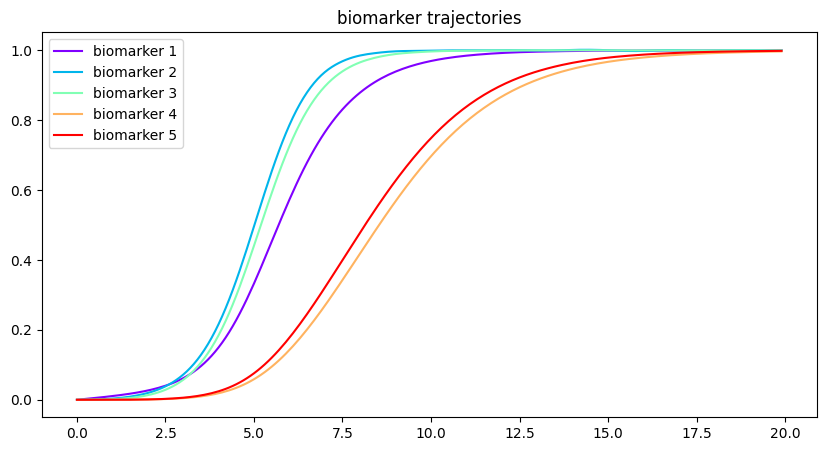

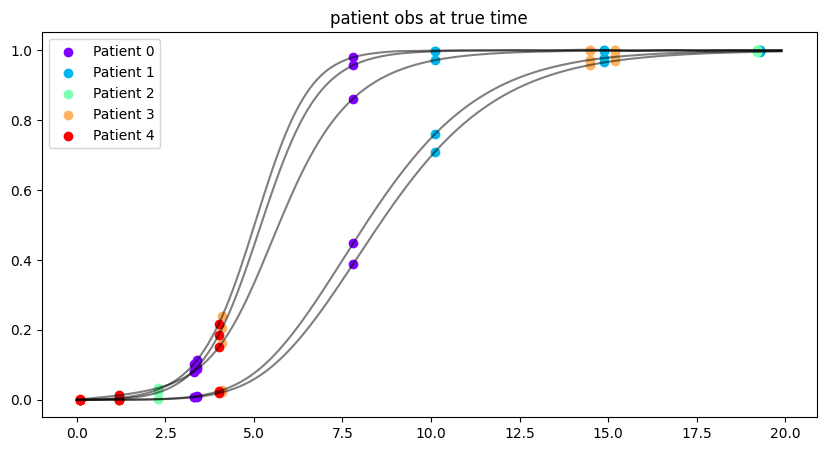

In [4]:
import matplotlib.pyplot as plt

### plot of biomarker trajectories over time
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))

plt.figure(figsize=(10, 5))
for i in range(n_biomarkers):
    plt.plot(t, x_true[i], label=f'biomarker {i+1}', color = colors[i])
plt.title("biomarker trajectories")
plt.legend()
plt.show()

### visualization of patient visits

patient_idx = [0, 1, 2, 3, 4] # <----- MODIFY idx to view specific patients(s)

plt.figure(figsize=(10, 5))
for i in range(n_biomarkers):
    plt.plot(t, x_true[i], color="k", alpha=0.5)

patient_colors = plt.cm.rainbow(np.linspace(0, 1, len(patient_idx)))

color_index = 0
for patient in patient_idx:
    patient_data = df[df["patient_id"] == patient]
    t_ij = patient_data["beta_true"] + patient_data["dt"] 
    
    for i in range(n_biomarkers):
        plt.scatter(t_ij, patient_data[f"biomarker_{i+1}"], color=patient_colors[color_index], label="Patient " + str(patient) if i == 0 else None)
    #  if statement is there to stop duplicate labels
    color_index += 1

plt.title("patient obs at true time")
plt.legend()
plt.show()



## M-step pt 1.
First lets fit the parameters of the ODEs using our longitudinal data, since we do not know time we guess a $\beta_{i}$ for every subject, and then we will add that onto our relative measurements on a per patient basis, then we just used the lsq function to get the parameters of our model.

First let's just make an initial guess for patient onset $\beta$ which is randomly assigned.

Recall: $ s_{ij} = \alpha_{i}+\beta_{i}$ where alpha is the timescale and is redundant. We are primarily concerned with the timeshift $\beta_{i}$. Leaving us with this formulation $$t_{ij} = \beta_{i} + \Delta t_{ij}$$

First observation $S_{i1} = \beta_{i}$

In [5]:
def initialize_beta(df, beta_range=(0, t_max)) -> pd.DataFrame: #TODO: make it dynamic, also I think it should go negative?
    """
    Uniformly randomly initalizes beta values for each patient ID with range [0, tmax]. 
    Later to be updated by appending columns of later iterations of beta
    """
    
    df = df.copy()
    patient_ids = df["patient_id"].unique()
    
    beta_values = []
    for i in range(len(patient_ids)):
        beta_values.append(np.random.uniform(beta_range[0], beta_range[1]))

    beta_column = np.zeros(len(df))

    # assignment
    # TODO: this loop can be replaces by a good dict comprehension
    for i in range(len(df)):
        patient_id = df.iloc[i]["patient_id"]
        
        for j in range(len(patient_ids)):
            if patient_ids[j] == patient_id:
                beta_column[i] = beta_values[j]
                break  # break search after finding patient

    beta_iter = pd.DataFrame(df["patient_id"])
    beta_iter["0"] = beta_column

    return beta_iter

beta_iter = initialize_beta(df)

print(beta_iter.head(7))

   patient_id         0
0           0  2.040826
1           0  2.040826
2           0  2.040826
3           1  1.521751
4           1  1.521751
5           1  1.521751
6           2  9.633659


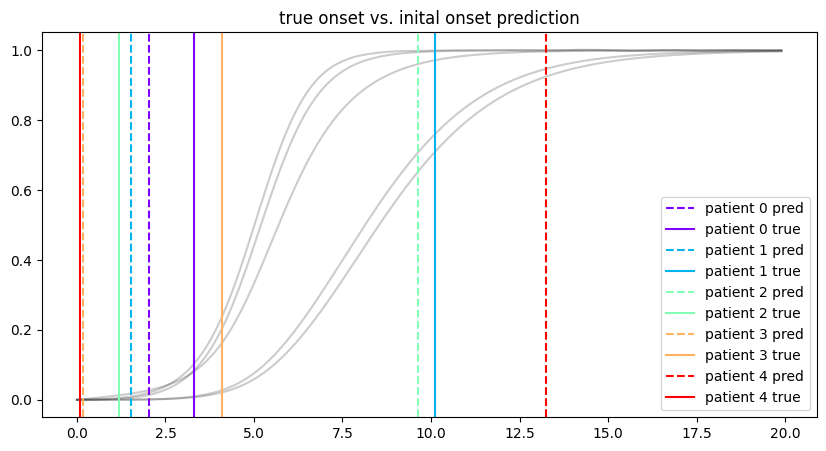

In [6]:
import matplotlib.pyplot as plt

patient_idx = [0, 1, 2, 3, 4]

plt.figure(figsize=(10, 5))
for i in range(n_biomarkers):
    plt.plot(t, x_true[i], color="k", alpha=0.2)

patient_colors = plt.cm.rainbow(np.linspace(0, 1, len(patient_idx)))
color_index = 0
for patient in patient_idx:
    beta_guess = beta_iter.loc[beta_iter["patient_id"] == patient, "0"].values[0]
    beta_true = df[df["patient_id"] == patient]["beta_true"].iloc[0]
    plt.axvline(x=beta_guess, color=patient_colors[color_index], linestyle="--", label="patient " + str(patient) + " pred")
    plt.axvline(x=beta_true, color=patient_colors[color_index], linestyle="-", label="patient " + str(patient) + " true")
    color_index += 1  

plt.title("true onset vs. inital onset prediction")
plt.legend()
plt.show()


In [7]:
def reconstruct_trajectories(x0, f, K, t, step=0.1) -> np.ndarray:
    """
    reconstructs entire curve using supplied params, for integrating, indexing, plotting purposes
    
    returns:
        x_reconstructed: np.ndarray contains predicted biomarker values.
    """

    n_biomarkers = len(x0)
    x_reconstructed = np.zeros((n_biomarkers, len(t)))
    x_reconstructed[:, 0] = x0

    for i in range(len(t) - 1):
        dx_dt = multi_logistic_deriv_force(t[i], x_reconstructed[:, i], K, f)
        x_reconstructed[:, i + 1] = x_reconstructed[:, i] + dx_dt * step

    return x_reconstructed

Now that beta has been initialized, we cannot find better estimations of beta until we have a prediction of what theta is for our underlying model. Only then can we update beta. To find theta we need to find the theta that minimizes the loss between our predicted by doing $$f(\beta_i+\Delta t_{ij})$$

The data stored in each row of our df is our $y_i$. Our loss function should measure the difference between the true biomarker values $y_i$ and our predicted values from the ODE model with predicted parameters: 
$$L(\theta) = \sum_{i} \left( f(t_{ij}; \hat{\theta}) - y_i \right)^2, x_{pred} - x_{obs}$$

We assume that the $y_i$ comes from our true $\theta$ parameters, as opposed to the function which we can only predict and try to get closer to better fits the data over our iterations.





In [8]:
from scipy.optimize import minimize

def multi_logistic_deriv_force(t, x, K, f):
    x = np.maximum(x, 0)  # ensure non-negativity
    dx_dt = np.dot(np.eye(len(K)) - np.diag(x), np.dot(K, x) + f)
    return dx_dt.flatten()

def theta_lsq(params, t_obs, x_obs, K, step=0.1, t_span=None):
    """
    Residue function call: computes difference between x_obs (from df) and x_pred (from interp)
    x_pred got by solving for x from dx_dt by integrating.
    """
    n_biomarkers = x_obs.shape[0]

    x0 = params[:n_biomarkers]
    f = params[n_biomarkers:]

    x = reconstruct_trajectories(x0, f, K, t_span, step=step)

    # Interpolation to match observed timing
    x_pred = np.zeros((n_biomarkers, len(t_obs)))
    for j in range(n_biomarkers):
        x_pred[j] = np.interp(t_obs, t_span, x[j])

    residuals = x_obs.flatten() - x_pred.flatten()
    return residuals

def fit_theta(df_opt, beta_iter, iteration, K, step=0.1, t_span=t_span):
    """
    Optimizes theta = [x_0, f] using LSQ to minimize residuals between
    observed and predicted biomarker values.
    
    accesses beta_iter to recompute `t_ij` at the current iteration.
    """
    # Compute t_ij dynamically using the current beta iteration
    t_obs = df_opt["dt"].values + beta_iter[str(iteration)].values  # predicted absolute times t_ij for each patient and visit
    x_obs = df_opt[[col for col in df_opt.columns if "biomarker_" in col]].values.T  # actual biomarker values

    #print(t_obs.shape)  # should be (n_patients * visits,)
    #print(x_obs shape)  # should be (n_biomarkers, n_patients * visits)
    
    n_biomarkers = x_obs.shape[0]
    
    ### boundaries
    x0_min, x0_max = 0, 0.1
    f_min, f_max = 0, 0.2

    # randomly initialize guesses
    x0_guess = np.random.uniform(x0_min, x0_max, size=n_biomarkers)
    f_guess = np.random.uniform(f_min, f_max, size=n_biomarkers)
    params_guess = np.concatenate([x0_guess, f_guess])

    # one initial conc and f for each biomarker
    bounds = [(x0_min, x0_max)] * n_biomarkers + [(f_min, f_max)] * n_biomarkers

    ### Optimization
    result = minimize(
        lambda params: np.sum(theta_lsq(params, t_obs, x_obs, K, step=step, t_span=t_span)**2),
        params_guess,
        method="L-BFGS-B",
        bounds=bounds
    )

    x0_fit = result.x[:n_biomarkers]
    f_fit = result.x[n_biomarkers:]

    return x0_fit, f_fit


Above is good but, needs to be more interesting. This is where we introduce the jacobian into the optimization. Using scipy's jac 

## M-step pt 2.

$$\hat{\beta_{i}} = \arg\min_{\beta_i} \sum_{l,i,j} \left\| V_{ij}^l - f_{\zeta}(\beta_i + \Delta t_{ij}; \theta) \right\|^2 + \frac{\sigma_s}{\sigma_l} (\beta_i - S_i)^2$$

- $V_{ij}^l$ is the observed value of biomarker $l$ for patient $i$ at observation (visit) $j$
- $f_{\zeta}(\beta_i + \Delta t_{ij}; \theta)$ is the predicted biomarker value from the logistic model, given $\theta$ and time shift $\beta_i$
- $ S_i $ is prior knowledge about the disease stage of patien????
- $\sigma_s$ variance of the prior on $S_i$
- $\sigma_l$ variance of the biomarker noise


jacobian of loss function

In [9]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def beta_loss(beta_i, dt_obs, x_obs, x_reconstructed, t_span):
    """
    Computes the loss function for optimizing current beta_i.
    
    Assuming we already have predicted theta, we take in he predicted model values
    and compute the time values associated with each predicted observation.
    
    Then we compute the predicted values at the predicted time, then compute the residual.
    """
    t_adjusted = dt_obs + beta_i  # Adjust time by beta_i
    x_pred = np.zeros_like(x_obs)

    # get values of biomarkers from predicted values, by iterating over all biomarkers
    for j in range(x_obs.shape[0]):  
        x_pred[j, :] = np.interp(t_adjusted, t_span, x_reconstructed[j])

    residuals = np.sum((x_obs - x_pred) ** 2)
    return residuals # make sure this is a 1D scipy array

def beta_jac(beta_i, dt_obs, x_obs, x_reconstructed, t_span):
    """
    Derivative (gradient) of loss function wrt beta_i.
    dL/d(beta_i) = 2 * sum_j sum_t (f_j(beta_i + dt) - x_ijt) * df_j/dt (beta_i + dt)
    
    its the same as above however, finite difference is used to get df_j/dt (beta_i + dt)
    """
    t_adjusted = dt_obs + beta_i
    
    # zeros is syntactic sugar for getting an array the size of whats passed through 
    x_pred = np.zeros_like(x_obs)
    df_dt = np.zeros_like(x_obs)  # Derivative of f with respect to time

    # get derivative for each biomarker
    for j in range(x_obs.shape[0]):
        x_pred[j, :] = np.interp(t_adjusted, t_span, x_reconstructed[j])

        # c
        h = 1e-4  # step size
        f_forward = np.interp(t_adjusted + h, t_span, x_reconstructed[j])
        f_backward = np.interp(t_adjusted - h, t_span, x_reconstructed[j])
        df_dt[j, :] = (f_forward - f_backward) / (2 * h)

    # compute gradient dL/dbeta_i
    gradient = 2 * np.sum((x_pred - x_obs) * df_dt)

    return np.array([gradient])  # make sure this is a 1D scipy array

def estimate_beta_for_patient(df_patient, x_reconstructed, t_span):
    """
    Estimates beta_i for a single patient, this will be run over all patients.
    """
    dt_obs = df_patient["dt"].values  # relative visit time within each patient
    x_obs = df_patient[[col for col in df_patient.columns if "biomarker_" in col]].values.T  # biomarker values for each time point for each biomarker
    score_obs = df_patient["cognitive_score"].values

    beta_guess = np.mean(dt_obs)
    #beta_guess = np.median(t_obs)

    ### Optimization
    result = minimize(
        beta_loss,
        x0=[beta_guess],
        args=(dt_obs, x_obs, x_reconstructed, t_span),
        jac=beta_jac,
        bounds=[(0, t_max)],
        method="L-BFGS-B"
    )

    return result.x[0]


In [10]:
from tqdm import tqdm
num_iterations = 150  # TODO: Adjust based on some convergence criteria

beta_iter = initialize_beta(df)

# print(beta_iter.shape) # ensure there is only 1 beta per patient
# print(f"{beta_iter['patient_id'].nunique()} unique patients")

theta_iter = pd.DataFrame(columns=[f"iter_{i}" for i in range(num_iterations)]) # pre instantiate theta matrix for each iter
df_copy = df.copy()  # Preserve a copy in case this is run again

for iteration in tqdm(range(num_iterations)):
    #print(f"iteration {iteration + 1}")

    ### M-step 1: estimate theta
    x0_fit, f_fit = fit_theta(df_copy, beta_iter, iteration, K)
    theta_iter[f"iter_{iteration}"] = np.concatenate([x0_fit, f_fit])

    t_span = np.linspace(0, t_max, 100)
    x_reconstructed = reconstruct_trajectories(x0_fit, f_fit, K, t_span) # reconstruct the trajectories with our current theta params

    ### M-step 2: estimate beta based off current theta iter
    beta_estimates = {}

    for patient_id, df_patient in df_copy.groupby("patient_id"):
        beta_estimates[patient_id] = estimate_beta_for_patient(df_patient, x_reconstructed, t_span)

    # merge or concatenate should be used otherwise pandas throws a fit about memory efficiency. 
    beta_update_df = pd.DataFrame(list(beta_estimates.items()), columns=["patient_id", str(iteration + 1)])
    beta_iter = beta_iter.merge(beta_update_df, on="patient_id", how="left")

    df_copy["beta"] = beta_iter[str(iteration)]
    df_copy["t_ij"] = df_copy["beta"] + df_copy["dt"] # recompute t_j from most recent beta_iter

print("Done!")


100%|██████████| 150/150 [01:32<00:00,  1.62it/s]

Done!


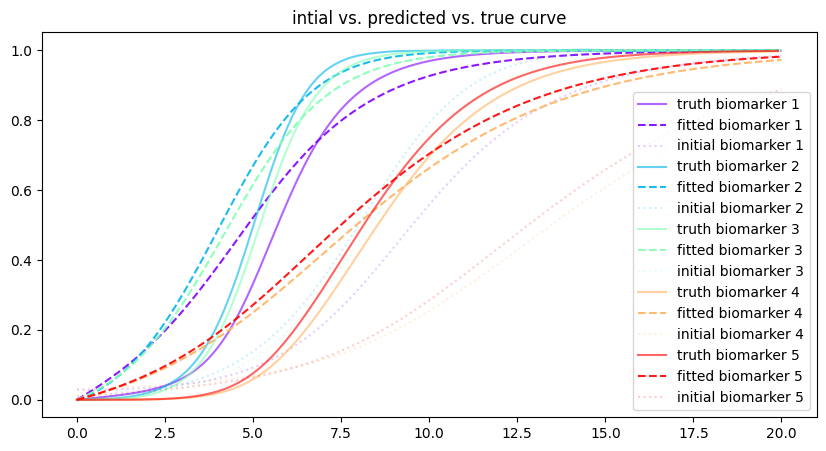

In [11]:
x0_final = theta_iter[f"iter_{num_iterations-1}"].values[:n_biomarkers]
f_final = theta_iter[f"iter_{num_iterations-1}"].values[n_biomarkers:]
x_final = reconstruct_trajectories(x0_final, f_final, K, t_span)

x0_init = theta_iter[f"iter_{0}"].values[:n_biomarkers]
f_init = theta_iter[f"iter_{0}"].values[n_biomarkers:]
x_init = reconstruct_trajectories(x0_init, f_init, K, t_span)

colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))

plt.figure(figsize=(10, 5))
for i in range(n_biomarkers):
    plt.plot(t, x_true[i], linestyle="-", color=colors[i], alpha=0.6, label=f'truth biomarker {i+1}')
    plt.plot(t_span, x_final[i], linestyle ="--",color=colors[i], alpha=0.9, label=f'fitted biomarker {i+1}')
    plt.plot(t_span, x_init[i],color=colors[i], alpha=0.2, label=f'initial biomarker {i+1}', linestyle=":")

plt.title("intial vs. predicted vs. true curve")
plt.legend()
plt.show()


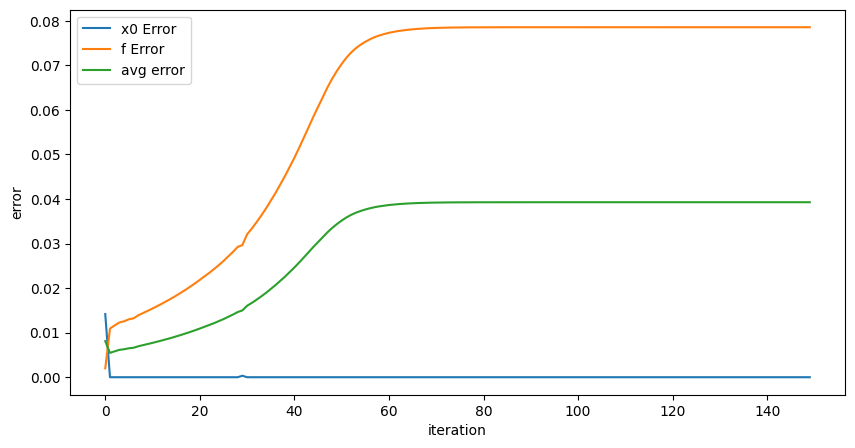

In [12]:
# just copied from above as a reminder
x0_true = np.zeros(n_biomarkers)
f_true = np.zeros(n_biomarkers)
f_true[0] = 0.01

x0_error_history = []
f_error_history = []
avg_theta_error = []

for iteration in range(num_iterations):
    theta_column = f"iter_{iteration}"
    if theta_column in theta_iter.columns:
        x0_estimated = theta_iter[theta_column].values[:n_biomarkers]  # first part of theta is x0
        f_estimated = theta_iter[theta_column].values[n_biomarkers:]  # second part of theta is f
        
        # get mean
        x0_error = np.mean(np.abs(x0_true - x0_estimated))
        f_error = np.mean(np.abs(f_true - f_estimated))
        avg_error = (x0_error + f_error) / 2  # Average theta error
        
        x0_error_history.append(x0_error)
        f_error_history.append(f_error)
        avg_theta_error.append(avg_error)

plt.figure(figsize=(10, 5))
plt.plot(range(num_iterations), x0_error_history, label="x0 Error")
plt.plot(range(num_iterations), f_error_history, label="f Error")
plt.plot(range(num_iterations), avg_theta_error, label="avg error")
plt.xlabel("iteration")
plt.ylabel("error")
plt.legend()
plt.show()


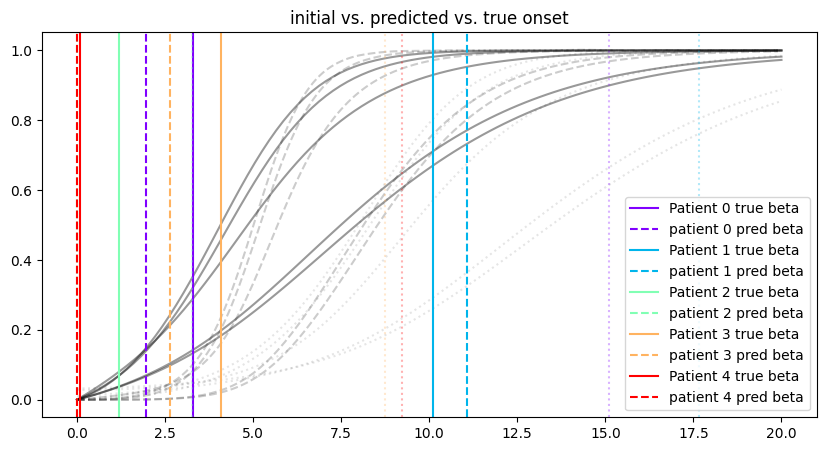

In [13]:
x0_final = theta_iter[f"iter_{num_iterations-1}"].values[:n_biomarkers]
f_final = theta_iter[f"iter_{num_iterations-1}"].values[n_biomarkers:]
x_final = reconstruct_trajectories(x0_final, f_final, K, t_span)

x0_init = theta_iter[f"iter_{0}"].values[:n_biomarkers]
f_init = theta_iter[f"iter_{0}"].values[n_biomarkers:]
x_init = reconstruct_trajectories(x0_init, f_init, K, t_span)

patients = df["patient_id"].unique()[:5] # grabbing first 5 patients

beta_colors = plt.cm.rainbow(np.linspace(0, 1, len(patients)))
biomarker_color = "k"

plt.figure(figsize=(10, 5))

# curve plot like above
for i in range(n_biomarkers):
    plt.plot(t, x_true[i], linestyle="--", color=biomarker_color, alpha=0.2)
    plt.plot(t_span, x_final[i], color=biomarker_color, alpha=0.4)
    plt.plot(t_span, x_init[i], color=biomarker_color, alpha=0.1, linestyle=":")

# vertical lines denotign beta
for idx, patient_id in enumerate(patients):
    beta_true = df[df["patient_id"] == patient_id]["beta_true"].iloc[0]
    beta_estimated = beta_iter.loc[beta_iter["patient_id"] == patient_id, str(num_iterations)].values[0]
    beta_init = beta_iter.loc[beta_iter["patient_id"] == patient_id, str(0)].values[0]

    plt.axvline(x=beta_true, color=beta_colors[idx], linestyle="-", label=f"Patient {patient_id} true beta")
    plt.axvline(x=beta_estimated, color=beta_colors[idx], linestyle="--", label=f"patient {patient_id} pred beta") # "--" dashed
    plt.axvline(x=beta_init, color=beta_colors[idx], linestyle=":", alpha = 0.3)

plt.title("initial vs. predicted vs. true onset")
plt.legend()
plt.show()


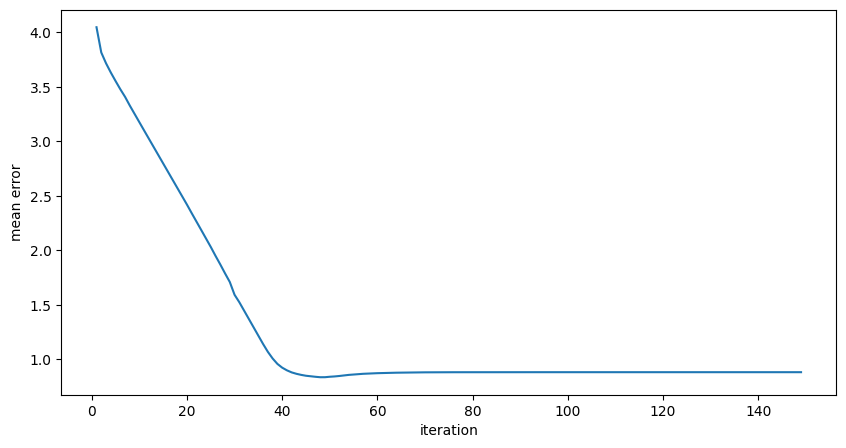

In [14]:
beta_error_history = []

for iteration in range(1, num_iterations + 0):
    beta_column = str(iteration)
    if beta_column in beta_iter.columns:  # Ensure iteration exists in beta_iter
        beta_estimated = beta_iter[["patient_id", beta_column]].rename(columns={beta_column: "beta_estimated"})
        beta_diff = df[["patient_id", "beta_true"]].merge(beta_estimated, on="patient_id")
        beta_diff["beta_error"] = np.abs(beta_diff["beta_true"] - beta_diff["beta_estimated"])
        beta_error_history.append(beta_diff["beta_error"].mean())  # Track mean error

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(beta_error_history) + 1), beta_error_history)
plt.xlabel("iteration")
plt.ylabel("mean error")
plt.show()


In [15]:
def print_description(beta_iter, df, iteration=None):
    if iteration is None:
        iteration = beta_iter.columns[-1]  # just get last iteration column

    beta_estimated = beta_iter[["patient_id", iteration]].rename(columns={iteration: "beta_estimated"})
    df_unique = df[["patient_id", "beta_true"]].drop_duplicates(subset=["patient_id"])
    beta_estimated_unique = beta_estimated.drop_duplicates(subset=["patient_id"])
    
    beta_diff = df_unique.merge(beta_estimated_unique, on="patient_id")

    # difference
    beta_diff["beta_error"] = np.abs(beta_diff["beta_true"] - beta_diff["beta_estimated"])

    print("Iteration: {}".format(iteration))
    print(beta_diff["beta_error"].describe())
    print("\n")

    return beta_diff

initial_beta_analysis = print_description(beta_iter, df, iteration="0")
final_beta_analysis = print_description(beta_iter, df)


Iteration: 0
count    100.000000
mean       7.188422
std        5.477769
min        0.131118
25%        2.366686
50%        6.286589
75%       11.757500
max       18.277179
Name: beta_error, dtype: float64


Iteration: 150
count    100.000000
mean       0.882374
std        0.672457
min        0.010890
25%        0.429000
50%        0.766451
75%        1.161085
max        4.157831
Name: beta_error, dtype: float64


